In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow as tf

ImportError: cannot import name 'export_saved_model' from 'tensorflow.python.keras.saving.saved_model' (c:\Users\Usuario\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\saving\saved_model\__init__.py)

In [2]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test'

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

# **Creating Data Generators**

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                               rotation_range = 20,
                                                               brightness_range= (1.2, 1.5),
                                                               horizontal_flip = True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [5]:
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size =(IMG_HEIGHT, IMG_WIDTH),
                                              class_mode = 'binary',
                                              batch_size = BATCH_SIZE)
val_data = val_datagen.flow_from_directory(val_dir,
                                              target_size =(IMG_HEIGHT, IMG_WIDTH),
                                              class_mode = 'binary',
                                              batch_size = BATCH_SIZE)
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size =(IMG_HEIGHT, IMG_WIDTH),
                                              class_mode = 'binary',
                                              batch_size = BATCH_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# BUILDING MODEL


In [6]:
mobilenet = tf.keras.applications.MobileNetV2(input_shape = (IMG_HEIGHT,IMG_WIDTH, 3),
                                              include_top = False,
                                              weights = 'imagenet',
                                              pooling='avg')

mobilenet.trainable = False

2022-07-26 10:12:24.549329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:12:24.641151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:12:24.641951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 10:12:24.643880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation="relu")(pretrained_model)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense)

model = tf.keras.Model(inputs, outputs)


print(model.summary())
    
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [8]:
EPOCHS = 50

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
             metrics = ['accuracy',
                       tf.keras.metrics.AUC(name='auc')])

history = model.fit(train_data,
                   validation_data = val_data,
                   batch_size=BATCH_SIZE,
                   epochs = EPOCHS,
                   callbacks = [tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience = 3,
                   restore_best_weights=True)])

2022-07-26 10:12:30.218204: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-26 10:12:34.540916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 168s 979ms/step - loss: 0.2218 - accuracy: 0.9227 - auc: 0.9605 - val_loss: 0.1510 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 2/50
163/163 [==============================] - 117s 720ms/step - loss: 0.1144 - accuracy: 0.9569 - auc: 0.9892 - val_loss: 0.1527 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 3/50
163/163 [==============================] - 116s 709ms/step - loss: 0.0979 - accuracy: 0.9595 - auc: 0.9918 - val_loss: 0.1641 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 4/50
163/163 [==============================] - 114s 702ms/step - loss: 0.0885 - accuracy: 0.9655 - auc: 0.9932 - val_loss: 0.1571 - val_accuracy: 0.8750 - val_auc: 1.0000


# Results

In [9]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype =np.int))

cm = confusion_matrix(true_labels, pred_labels)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [10]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

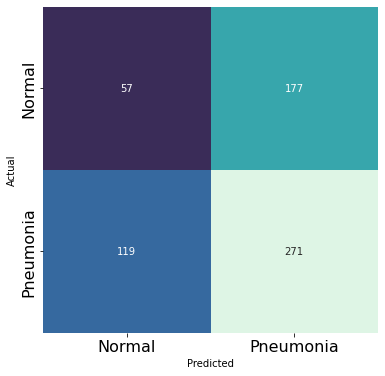

In [11]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()



In [12]:
results = model.evaluate(test_data, verbose = 0)


In [13]:
accuracy = results[1]
auc = results[2]

In [14]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [15]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.87
AUC: 0.96
Precision: 0.60
Recall: 0.69
